## Model following KK10

NB: Vmin has an impact on L. See how I handle this. One idea would be to use storm_speed as an ersatz for Vmin.

In [1]:
# General
import glob
import re
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit

# Custom
import functions as f
import dataUtils as du

# Statistics
from sklearn import linear_model, neighbors
from pykalman import KalmanFilter

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
# PATHS = {
#     'ds_glob_path':    '/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_13052022_with_extra_params.nc',
#     'sar_dir':         '/home/arthur/data/cyclobs/centered_rotated_files_31012022/',
#     'sct_dir':         '/home/arthur/data/scatterometer/KNMI/product_JF_rotated_filtered_v3/POLAR/2020/EP182020/',
# }

In [30]:
####-----------####
#### FUNCTIONS ####
####-----------####

### MODEL
def coriolis(lat):
    '''Absolute vorticity.
    Latitude must be in degrees.'''
    Omega = 7.2921e-5                            # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter at 20° latitude and assuming it's constant 
    return fcor

def vorticity(r, v):
    '''Relative vorticity'''
    dr = 1000 # meters
    return (1 / r) * np.gradient(r * v, dr)

def charac_length(V):
    '''Given a wind profile object V, returns its characteristic length L'''
    rel_vort = vorticity(V.rad, V.ws)
    abs_vort = coriolis(V.lat)
    q        = (V.rad * V.ws ** 2) / (rel_vort + abs_vort)
    return V.rad[np.nanargmax(q)]

def get_scales(V, show=False):
    # Fit Holland
    vmx, rmx, B, vmn = fit_h80(V)
    # Compute L on Vh relative (vmin = 0)
    Vh_rel = xr.Dataset(
        data_vars={
            'ws': ('rad', h80(V.rad, vmx, rmx, B, V.lat, 0).data),
            'lat': V.lat.data,
            'time': V.time.data,
        },
        coords={
            'rad': V.rad.data
        }
    )
    # Compute scales
    L      = charac_length(Vh_rel) # Vmin must be 0
    U_star = coriolis(Vh_rel.lat) * rmx
    
    if show:
        print('L  = {:.0f} km'.format(L / 1000))
        print('U* =  {:.1f} m/s'.format(U_star))
        print('T  = {:.1f} h'.format(L / U_star / 3600))        
    return L, U_star
    
def nb_of_timesteps(L, U_star, delta_t):
    return delta_t / (L / U_star)

def non_dimensional(V, L):
    V_nd = xr.DataArray(
        data=V.ws / (coriolis(V.lat) * L),
        coords={'rad': V.rad / L}
    )
    return V_nd

def dimensional(ws, V, L):
    V_nd = xr.DataArray(
        data=ws * coriolis(V.lat) * L,
        coords={'rad': V.rad}
    )
    return V_nd

def h80(r, vm, rm, B, lat, vmin):
    '''Holland 1980 profile.'''
    fcor = coriolis(lat)
    V    = r * 0.
    V    = vmin + np.sqrt((vm ** 2) * ((rm / r) ** B) * np.exp(1 - (rm / r) ** B) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

def fit_h80(V):
    '''Given an xr.Dataset V of wind speed 'ws' with 'rad' as dim & coord (m) and 'lat' as second variable,
    returns the parameters of fitted Holland 1980 profile.
    CAVEAT: coordinate 'rad' must be > 0, else the residuals are not finite for r = 0.
    '''
    popt, pcov = curve_fit(
        f=lambda r, vm, rm, B, vmin: h80(r, vm, rm, B, V.lat, vmin),
        xdata=V.rad,
        ydata=V['ws'],
        p0=[V['ws'].max(), V.rad[V['ws'].argmax()], 1.5, V['ws'].min()],
        bounds=[
            (V['ws'].max() * 0.5, V.rad[V['ws'].argmax()] * 0.5, 0.5, V['ws'].min() * 0.5),
            (V['ws'].max() * 1.5, V.rad[V['ws'].argmax()] * 1.5, 5,   V['ws'].min() * 1.5)
        ]
    )
    return popt # Vmax, Rmax, B, Vmin

def v_kk11(v0, t, lbda):
    '''Given an initial wind profile v0, propagates according to KK11 and using lambda'''
    v          = np.zeros_like(v0.rad)
    # Inner-core
    v_prop_in  = v0.interp({'rad': v0.rad * np.exp(t)})
    vin        = v_prop_in * np.exp((1 - lbda) * t) + v0.rad * (1 - np.exp((2 - lbda) * t)) / (lbda - 2)
    # Near-core
    nr_term    = np.sqrt(1 + 2 * (np.log(v0.rad) + t))
    v_prop_nr  = v0.interp({'rad': nr_term})
    vnr        = nr_term * v_prop_nr * np.exp(-lbda * t) / v0.rad + (lbda * v0.rad ** 2 - 2 * v0.rad ** lbda) / (lbda * v0.rad * (lbda - 2)) - np.exp(-lbda * t) / (lbda * v0.rad)
    # Outer-core
    ou_term    = np.sqrt(v0.rad ** 2 + 2 * t)
    v_prop_ou  = v0.interp({'rad': ou_term})
    vou        = ou_term * v_prop_ou * np.exp(-lbda * t) / v0.rad + (1 - np.exp(-lbda * t)) / (lbda * v0.rad)

    # Declare final output
    bd              = np.exp(-t)
    v[v0.rad < bd]  = vin[v0.rad < bd]
    v[v0.rad >= bd] = vnr[v0.rad >= bd]
    v[v0.rad >= 1]  = vou[v0.rad >= 1]
    
    return v

In [4]:
### PARAMS
rs      = np.linspace(10, 5e5, 50000) # Take a lot of points to compute vorticity properly
delta_t = 6 * 3600                    # s

/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/lib-dynload/../../libffi.so.8: version `LIBFFI_CLOSURE_7.0' not found (required by /home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/_cffi_backend.cpython-38-x86_64-linux-gnu.so)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


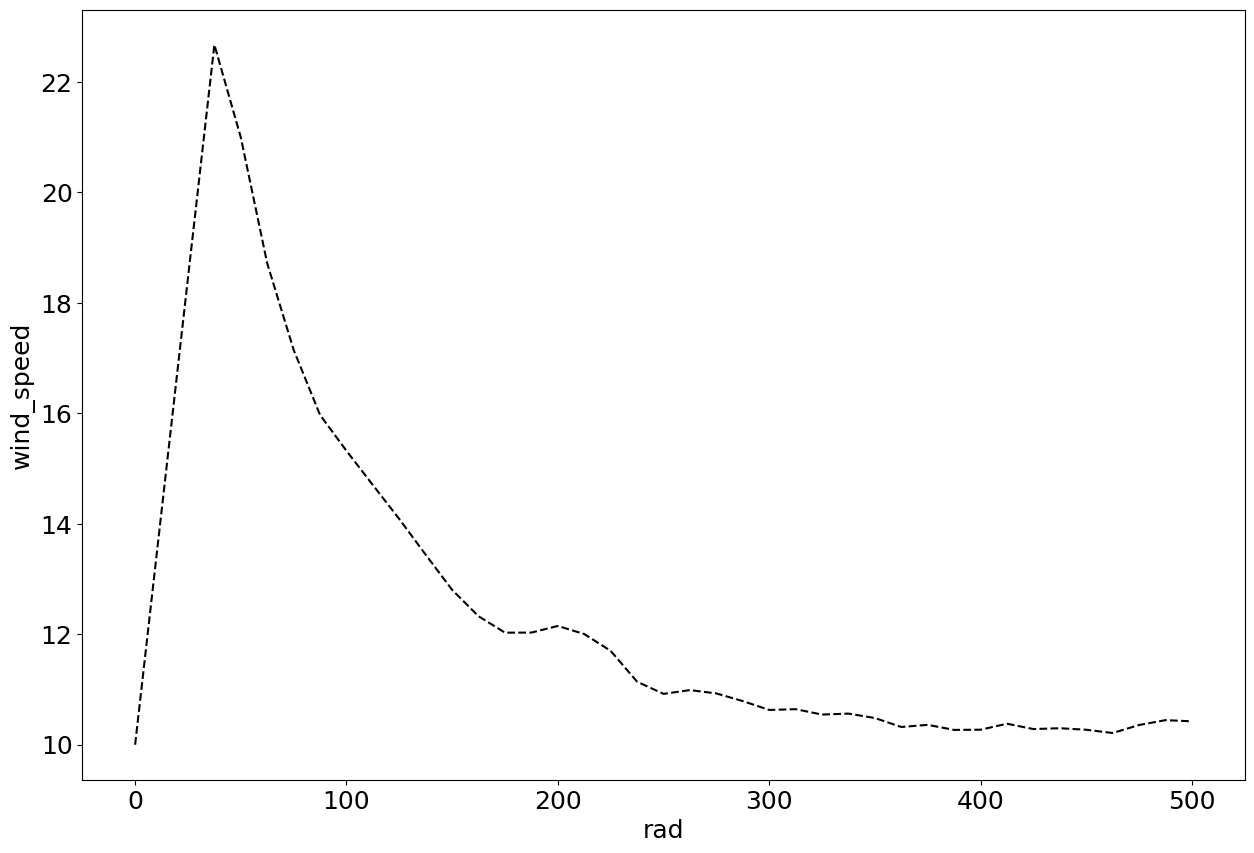

In [5]:
p   = '/home/arthur/data/scatterometer/KNMI/product_JF_rotated_filtered_v3/POLAR/2020/EP182020/POL_ascat_20201001_044800_metopb_41705_srv_o_125_ovw.nc'
dss = xr.open_dataset(p)

# Custom initialization
def affine(vmax, vmin, rmax, r):
    return ((vmax - vmin) / (rmax - 0)) * r + vmin

V_ini        = dss.wind_speed.mean(dim='theta', skipna=True)
V_ini[0]     = 10
V_ini[1]     = affine(vmax=V_ini.sel(rad=37.5), vmin=10, rmax=37.5, r=1 * 12.5)
V_ini[2]     = affine(vmax=V_ini.sel(rad=37.5), vmin=10, rmax=37.5, r=2 * 12.5)
V_ini.plot(c='k', linestyle='--', label='custom total')
V_ini['rad'] = V_ini.rad * 1000
V_ini        = V_ini.interp({'rad': rs})

# Create the structure
Vi = xr.Dataset(
    data_vars={
        'ws':          ('rad', V_ini.data),
        'lat':         dss.lat_IBT.data,
        # 'storm_speed': dss.storm_speed_IBT.data,
        'time':        dss.acquisition_time.data,
    },
    coords={
        'rad': rs
    }
)

L  = 49 km
U* =  1.3 m/s
T  = 10.6 h


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


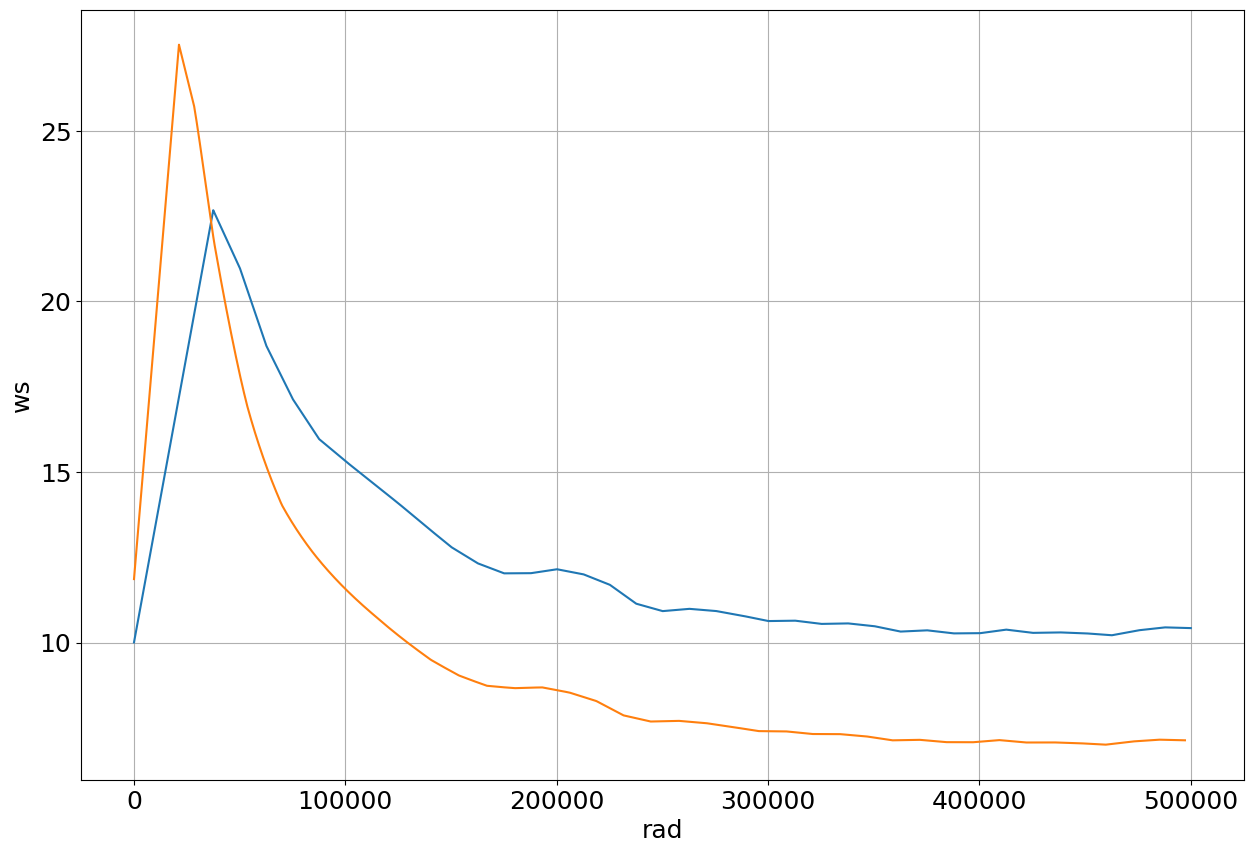

In [46]:
# Fit Holland
vmx, rmx, B, vmn = fit_h80(Vi)
# Get scales
L, U_star = get_scales(Vi, show=True)
# L *= 2
nt        = nb_of_timesteps(L, U_star, delta_t)
# Non-dimensionalization
Vi_nd     = non_dimensional(Vi, L)
# Get Kalashnik wind
Vk_nd     = xr.DataArray(
    data=v_kk11(Vi_nd, nt, lbda=0.7),
    coords={'rad': Vi_nd.rad}
)
# Dimensionalize
Vf = xr.Dataset(
    data_vars={
        'ws':          ('rad', dimensional(Vk_nd, Vi, L).data),
        'lat':         Vi.lat.data + 5 * delta_t * np.cos(np.pi / 4) / 110000, # assume TC goes at 5 m/s, with an angle 45° from North, and 1°N is 110 km
        # 'storm_speed': dss.storm_speed_IBT.data,
        'time':        Vi.time.data,
    },
    coords={
        'rad': Vi.rad.data
    }
)

Vi.ws.plot()
Vf.ws.plot()
plt.grid()

In [ ]:

# vh_test = h80(rs, vm=30, rm=50000, B=1, lat=20)
# plt.plot(rs / 1000, vh_test);plt.grid()

In [ ]:
### FUNCTIONS



def get_scales(ds, H=10000, show=True, L=100000, delta_t=24):
    lat    = float(ds.lat.isel(rad=0).mean(dim='theta', skipna=True))
    fcor   = abs(coriolis(lat)) # maybe divide by 10 to get reasonable value of fcor * L

    # To define U_star
    ws     = ds.wind_speed.mean(dim='theta', skipna=True)
    Rmax   = float(ws.rad[int(ws.argmax())]) # m
    Vmax   = float(ws.max())                  # m/s
    U_star = fcor * Rmax # m/s

    if show:
        print('characteristic time --> {:.1f} h'.format(L / U_star / 3600))
        print('radial velocity     --> {:.2f} m/s'.format(U_star))
        print('tangential velocity --> {:.2f} m/s'.format(fcor * L))
        print('vertical velocity   --> {:.2f} m/s'.format(H * U_star / L))
        print('characteristic tangential velocity --> {:.1f} m/s'.format(fcor * L)) 
        print('nb of timesteps: {:.2f}'.format(delta_t / (L / U_star / 3600)))
    
    return Vmax, Rmax, fcor

def get_v(ds, fcor, L):
    ws = ds.wind_speed.mean(dim='theta', skipna=True)
    r = ws.rad / L
    v = ws     / (fcor * L)

    V = xr.DataArray(
        data=v,
        coords={'rad': r}
    )
    return V

def v_k10(v0, t, lbda):
    v          = np.zeros_like(v0.rad)
    # Inner-core
    v_prop_in  = v0.interp({'rad': v0.rad * np.exp(t)})
    vin        = v_prop_in * np.exp((1 - lbda) * t) + v0.rad * (1 - np.exp((2 - lbda) * t)) / (lbda - 2)
    # Near-core
    nr_term    = np.sqrt(1 + 2 * (np.log(v0.rad) + t))
    v_prop_nr  = v0.interp({'rad': nr_term})
    vnr        = nr_term * v_prop_nr * np.exp(-lbda * t) / v0.rad + (lbda * v0.rad ** 2 - 2 * v0.rad ** lbda) / (lbda * v0.rad * (lbda - 2)) - np.exp(-lbda * t) / (lbda * v0.rad)
    # Outer-core
    ou_term    = np.sqrt(v0.rad ** 2 + 2 * t)
    v_prop_ou  = v0.interp({'rad': ou_term})
    vou        = ou_term * v_prop_ou * np.exp(-lbda * t) / v0.rad + (1 - np.exp(-lbda * t)) / (lbda * v0.rad)

    # Declare final output
    bd              = np.exp(-t)
    v[v0.rad < bd]  = vin[v0.rad < bd]
    v[v0.rad >= bd] = vnr[v0.rad >= bd]
    v[v0.rad >= 1]  = vou[v0.rad >= 1]
    
    return v

In [ ]:
# Define wind speeds
print('1)')
L1                  = 134000
Vmax1, Rmax1, fcor1 = get_scales(ds1, L=L1, delta_t=12)
V1                  = get_v(ds1, fcor1, L1)

print('\n2)')
L2                  = 142000
Vmax2, Rmax2, fcor2 = get_scales(ds2, L=L2, delta_t=24)
V2                  = get_v(ds2, fcor2, L2)

print('\n3)')
L3                  = 107000
Vmax3, Rmax3, fcor3 = get_scales(ds3, L=L3, delta_t=12)
V3                  = get_v(ds3, fcor3, L3)

print('\n4)')
L4                  = 146000
Vmax4, Rmax4, fcor4 = get_scales(ds4, L=L4, delta_t=24)
V4                  = get_v(ds4, fcor4, L4)

print('\n5)')
L5                  = 193000
Vmax5, Rmax5, fcor5 = get_scales(ds5, show=False, L=L5)
V5                  = get_v(ds5, fcor5, L5)

In [ ]:
# lbda  = 0.4
# v_new = v_k10(V1, t=0.29, lbda=lbda)
# plt.plot(ws1.rad, ws1, label='SAR t', c='k', linewidth=3)
# plt.plot(V1.rad * L1, v_new * fcor1 * L1, label='KK11', c='tab:orange')
# plt.plot(ws2.rad, ws2, label='SAR t + dt', c='k', linestyle='--')
# plt.grid();plt.xlim(0, 500000)
# plt.legend()

In [ ]:
# lbda  = -0.1
# v_new = v_k10(V2, t=0.45, lbda=lbda)
# plt.plot(ws2.rad, ws2, label='SAR t', c='k', linewidth=3)
# plt.plot(V2.rad * L2, v_new * fcor2 * L2, label='KK11', c='tab:orange')
# plt.plot(ws3.rad, ws3, label='SAR t + dt', c='k', linestyle='--')
# plt.grid();plt.xlim(0, 500000)
# plt.legend()

In [ ]:
# lbda  = 1.6
# v_new = v_k10(V3, t=0.42, lbda=lbda)
# plt.plot(ws3.rad, ws3, label='SAR t', c='k', linewidth=3)
# plt.plot(V3.rad * L3, v_new * fcor3 * L3, label='KK11', c='tab:orange')
# plt.plot(ws4.rad, ws4, label='SAR t + dt', c='k', linestyle='--')
# plt.grid();plt.xlim(0, 500000)
# plt.legend()

In [ ]:
# lbda  = 1.6
# v_new = v_k10(V4, t=0.65, lbda=lbda)
# plt.plot(ws4.rad, ws4, label='SAR t', c='k', linewidth=3)
# plt.plot(V4.rad * L4, v_new * fcor4 * L4, label='KK11', c='tab:orange')
# plt.plot(ws5.rad, ws5, label='SAR t + dt', c='k', linestyle='--')
# plt.grid();plt.xlim(0, 500000)
# plt.legend()

### 2) Scatterometer only

In [ ]:
### OPEN DATA
all_sct = glob.glob(PATHS['sct_dir'] + '*.nc')
print('nb of scat files = ', len(all_sct))

In [ ]:
def path2datetime(path):
    '''
    Given a path like: '/home/arthur/data/scatterometer/KNMI/metop_c/ascat/2019/025/ascat_20190125_144500_metopc_01131_srv_o_125_ovw.nc'
    returns the datetime object corresponding to acquisition start time: datetime.datetime(2019, 1, 25, 14, 45)
    '''
    dt_as_list = re.split(r'(\d+)', os.path.basename(path))[1:4] # ['20150403', '_', '071800']
    dt_conc    = ''.join(dt_as_list)                             # '20150403T071800'
    return datetime.strptime(dt_conc, "%Y%m%d_%H%M%S")

In [ ]:
# Sort all files
all_sct = sorted(all_sct, key=path2datetime)
# Custom list
all_sct = all_sct[22:]

#### Initialization

In [ ]:
# Initialization
dss = xr.open_dataset(all_sct[0])
dss.wind_speed.mean(dim='theta', skipna=True).plot(c='k', linewidth=3, label='SCAT total')
dss.tangential_wind.mean(dim='theta', skipna=True).plot(c='tab:red', label='SCAT tangential')
plt.axvline(37.5, c='k', alpha=0.3)

# Custom initialization
def affine(vmax, vmin, rmax, r):
    return ((vmax - vmin) / (rmax - 0)) * r + vmin

V_ini        = dss.wind_speed.mean(dim='theta', skipna=True)
V_ini[0]     = 10
V_ini[1]     = affine(vmax=V_ini.sel(rad=37.5), vmin=10, rmax=37.5, r=1 * 12.5)
V_ini[2]     = affine(vmax=V_ini.sel(rad=37.5), vmin=10, rmax=37.5, r=2 * 12.5)
V_ini.plot(c='k', linestyle='--', label='custom total')
plt.legend();plt.grid()

# Convert to meters
V_ini['rad'] = V_ini.rad * 1000

#### 1st iteration

In [ ]:
# Define characteristic scales
L      = 150000
fcor   = float(coriolis(dss.lat_IBT))
Rmax   = 37500
delta_t= 12 # hr
U_star = fcor * Rmax
print('radial velocity U*  --> {:.2f} m/s'.format(U_star))
print('characteristic time --> {:.1f} h'.format(L / U_star / 3600))
print('latitude            --> {:.1f}°'.format(dss.lat_IBT))
print('nb of timesteps: {:.2f}'.format(delta_t / (L / U_star / 3600)))


V0 = xr.DataArray(
    data=V_ini / (fcor * L),
    coords={'rad': V_ini.rad / L}
)

In [ ]:
lbda  = 0.3
v_new = v_k10(V0, t=0.40, lbda=lbda)

# INITIAL SCAT AND MODEL
plt.plot(V0.rad * L, V0 * fcor * L, label='SCT   at t = {}'.format(np.datetime_as_string(np.datetime64(path2datetime(all_sct[0])), unit='m')), c='k', linewidth=3)
plt.plot(V0.rad * L, v_new * fcor * L, label='KK11 at t + 12hr', c='tab:orange')

# NEXT SCAT
dss_next        = xr.open_dataset(all_sct[5])
dss_next['rad'] = dss_next.rad * 1000
v_next_sct      = dss_next.wind_speed.mean(dim='theta', skipna=True)
v_next_sct.plot(label='SCT at {}'.format(np.datetime_as_string(np.datetime64(path2datetime(all_sct[5])), unit='m')), c='k')

# INTERMEDIARY SAR AND MODEL
ws1.plot(label='SAR at {}'.format(np.datetime_as_string(ds1.time, unit='m')), c='c', linestyle='--', alpha=0.5)
plt.plot(V0.rad * L, v_k10(V0, t=0.30, lbda=lbda) * fcor * L, label='KK11 at t + 9hr', c='tab:orange', linestyle='--', alpha=0.5)

plt.title('1st iteration', weight='bold')
plt.grid();plt.xlim(0, 500000)
plt.legend()

### SAVE v_new
V_NEW = xr.DataArray(
    data=v_new * fcor * L,
    coords={'rad': V0.rad * L}
)

#### 2nd iteration

In [ ]:
# Define characteristic scales
L      = 130000
fcor   = float(coriolis(dss_next.lat_IBT))
Rmax   = 30000
delta_t= 12 # hr
U_star = fcor * Rmax
print('radial velocity U*  --> {:.2f} m/s'.format(U_star))
print('characteristic time --> {:.1f} h'.format(L / U_star / 3600))
print('nb of timesteps: {:.2f}'.format(delta_t / (L / U_star / 3600)))

V = xr.DataArray(
    data=V_NEW / (fcor * L),
    coords={'rad': V_NEW.rad / L}
)

In [ ]:
lbda  = 0.3
v_new = v_k10(V, t=0.37, lbda=lbda)

# INITIAL SCAT AND MODEL
plt.plot(V_NEW.rad, V_NEW,            label='KK11 at t ~ 10-01T16:40', c='tab:orange', linewidth=3)
plt.plot(V.rad * L, v_new * fcor * L, label='KK11 at t + 12hr', c='tab:orange')

# NEXT SCAT
dss_next        = xr.open_dataset(all_sct[8])
dss_next['rad'] = dss_next.rad * 1000
v_next_sct      = dss_next.wind_speed.mean(dim='theta', skipna=True)
v_next_sct.plot(label='SCT at {}'.format(np.datetime_as_string(np.datetime64(path2datetime(all_sct[8])), unit='m')), c='k')

# # INTERMEDIARY SAR AND MODEL
ws2.plot(label='SAR at {}'.format(np.datetime_as_string(ds2.time, unit='m')), c='c', linestyle='--', alpha=0.5)
plt.plot(V.rad * L, v_k10(V, t=0.3, lbda=lbda) * fcor * L, label='KK11 at t + 9hr30', c='tab:orange', linestyle='--', alpha=0.5)

plt.title('2nd iteration', weight='bold')
plt.grid();plt.xlim(0, 500000)
plt.legend()

### SAVE v_new
V_NEW = xr.DataArray(
    data=v_new * fcor * L,
    coords={'rad': V.rad * L}
)

#### 3rd iteration

In [ ]:
# Define characteristic scales
L      = 120000
fcor   = float(coriolis(dss_next.lat_IBT))
Rmax   = 22000
delta_t= 12 # hr
U_star = fcor * Rmax
print('radial velocity U*  --> {:.2f} m/s'.format(U_star))
print('characteristic time --> {:.1f} h'.format(L / U_star / 3600))
print('nb of timesteps: {:.2f}'.format(delta_t / (L / U_star / 3600)))

V = xr.DataArray(
    data=V_NEW / (fcor * L),
    coords={'rad': V_NEW.rad / L}
)

In [ ]:
lbda  = 0.1
v_new = v_k10(V, t=0.31, lbda=lbda)

# INITIAL SCAT AND MODEL
plt.plot(V_NEW.rad, V_NEW,            label='KK11 at t ~ 10-02T04:40', c='tab:orange', linewidth=3)
plt.plot(V.rad * L, v_new * fcor * L, label='KK11 at t + 12hr', c='tab:orange')

# NEXT SCAT
dss_next        = xr.open_dataset(all_sct[10])
dss_next['rad'] = dss_next.rad * 1000
v_next_sct      = dss_next.wind_speed.mean(dim='theta', skipna=True)
v_next_sct.plot(label='SCT at {}'.format(np.datetime_as_string(np.datetime64(path2datetime(all_sct[10])), unit='m')), c='k')

plt.title('3rd iteration', weight='bold')
plt.grid();plt.xlim(0, 500000)
plt.legend()

### SAVE v_new
V_NEW = xr.DataArray(
    data=v_new * fcor * L,
    coords={'rad': V.rad * L}
)

#### 4th iteration

In [ ]:
# Define characteristic scales
L      = 110000
fcor   = float(coriolis(dss_next.lat_IBT))
Rmax   = 11000
delta_t= 12 # hr
U_star = fcor * Rmax
print('radial velocity U*  --> {:.2f} m/s'.format(U_star))
print('characteristic time --> {:.1f} h'.format(L / U_star / 3600))
print('nb of timesteps: {:.2f}'.format(delta_t / (L / U_star / 3600)))

V = xr.DataArray(
    data=V_NEW / (fcor * L),
    coords={'rad': V_NEW.rad / L}
)

In [ ]:
lbda  = -0.1
v_new = v_k10(V, t=0.18, lbda=lbda)

# INITIAL SCAT AND MODEL
plt.plot(V_NEW.rad, V_NEW,            label='KK11 at t ~ 10-02T16:40', c='tab:orange', linewidth=3)
plt.plot(V.rad * L, v_new * fcor * L, label='KK11 at t + 12hr', c='tab:orange')

# # NEXT SCAT
### ==> NO VALID SCAT BEFORE 10-04t04:17

# # # INTERMEDIARY SAR AND MODEL
ws3.plot(label='SAR at {}'.format(np.datetime_as_string(ds3.time, unit='m')), c='c', linestyle='--', alpha=0.5)
plt.plot(V.rad * L, v_k10(V, t=0.15, lbda=lbda) * fcor * L, label='KK11 at t + 9hr30', c='tab:orange', linestyle='--', alpha=0.5)

plt.title('4th iteration', weight='bold')
plt.grid();plt.xlim(0, 500000)
plt.legend()

### SAVE v_new
V_NEW = xr.DataArray(
    data=v_new * fcor * L,
    coords={'rad': V.rad * L}
)

#### 5th iteration

In [ ]:
# Define characteristic scales
L      = 140000
fcor   = float(coriolis(dss_next.lat_IBT + 1.2)) # Data is missing ==> 1° is 100km, saying the storm goes at 10km/h, it has done ~1.2° in 12 hrs
Rmax   = 11000
delta_t= 12 # hr
U_star = fcor * Rmax
print('radial velocity U*  --> {:.2f} m/s'.format(U_star))
print('characteristic time --> {:.1f} h'.format(L / U_star / 3600))
print('latitude            --> {:.1f}°'.format(dss_next.lat_IBT + 1.2))
print('nb of timesteps: {:.2f}'.format(delta_t / (L / U_star / 3600)))

V = xr.DataArray(
    data=V_NEW / (fcor * L),
    coords={'rad': V_NEW.rad / L}
)

In [ ]:
lbda  = 2.5
v_new = v_k10(V, t=0.19, lbda=lbda)

# INITIAL SCAT AND MODEL
plt.plot(V_NEW.rad, V_NEW,            label='KK11 at t ~ 10-03T04:40', c='tab:orange', linewidth=3)
plt.plot(V.rad * L * 1.5, v_new * fcor * L, label='KK11 at t + 12hr', c='tab:orange')

# # NEXT SCAT
### ==> NO VALID SCAT BEFORE 10-04t04:17

# INTERMEDIARY SAR AND MODEL
ws4.plot(label='SAR at {}'.format(np.datetime_as_string(ds4.time, unit='m')), c='c', linestyle='--', alpha=0.5)
plt.plot(V.rad * L * 1.5, v_k10(V, t=0.15, lbda=lbda) * fcor * L, label='KK11 at t + 9hr30', c='tab:orange', linestyle='--', alpha=0.5)

plt.title('5th iteration', weight='bold')
plt.grid();plt.xlim(0, 500000)
plt.legend()

### SAVE v_new
V_NEW = xr.DataArray(
    data=v_new * fcor * L,
    coords={'rad': V.rad * L}
)

#### 6th iteration

In [ ]:
# Define characteristic scales
L      = 200000
fcor   = float(coriolis(dss_next.lat_IBT + 2 * 1.2)) # Data is missing ==> 1° is 100km, saying the storm goes at 10km/h, it has done ~1.2° in 12 hrs
Rmax   = 15000
delta_t= 12 # hr
U_star = fcor * Rmax
print('radial velocity U*  --> {:.2f} m/s'.format(U_star))
print('characteristic time --> {:.1f} h'.format(L / U_star / 3600))
print('nb of timesteps: {:.2f}'.format(delta_t / (L / U_star / 3600)))

V = xr.DataArray(
    data=V_NEW / (fcor * L),
    coords={'rad': V_NEW.rad / L}
)

In [ ]:
lbda  = 2.5
v_new = v_k10(V, t=0.15, lbda=lbda)

# INITIAL SCAT AND MODEL
plt.plot(V_NEW.rad, V_NEW,            label='KK11 at t ~ 10-03T16:40', c='tab:orange', linewidth=3)
plt.plot(V.rad * L * 3, v_new * fcor * L, label='KK11 at t + 12hr', c='tab:orange')

# NEXT SCAT
dss_next        = xr.open_dataset(all_sct[16])
dss_next['rad'] = dss_next.rad * 1000
v_next_sct      = dss_next.wind_speed.mean(dim='theta', skipna=True)
v_next_sct.plot(label='SCT at {}'.format(np.datetime_as_string(np.datetime64(path2datetime(all_sct[16])), unit='m')), c='k')

plt.title('6th iteration', weight='bold')
plt.grid();plt.xlim(0, 500000)
plt.legend()

### SAVE v_new
V_NEW = xr.DataArray(
    data=v_new * fcor * L,
    coords={'rad': V.rad * L}
)

#### 7th iteration

In [ ]:
# Define characteristic scales
L      = 300000
fcor   = float(coriolis(dss_next.lat_IBT))
Rmax   = 70000
delta_t= 12 # hr
U_star = fcor * Rmax
print('radial velocity U*  --> {:.2f} m/s'.format(U_star))
print('characteristic time --> {:.1f} h'.format(L / U_star / 3600))
print('latitude            --> {:.1f}°'.format(dss_next.lat_IBT))
print('nb of timesteps: {:.2f}'.format(delta_t / (L / U_star / 3600)))

V = xr.DataArray(
    data=V_NEW / (fcor * L),
    coords={'rad': V_NEW.rad / L}
)

In [ ]:
lbda  = 1.2
v_new = v_k10(V, t=0.49, lbda=lbda)

# INITIAL SCAT AND MODEL
plt.plot(V_NEW.rad, V_NEW,            label='KK11 at t ~ 10-04T04:40', c='tab:orange', linewidth=3)
plt.plot(V.rad * L * 4, v_new * fcor * L, label='KK11 at t + 12hr', c='tab:orange')

# NEXT SCAT
dss_next        = xr.open_dataset(all_sct[20])
dss_next['rad'] = dss_next.rad * 1000
v_next_sct      = dss_next.wind_speed.mean(dim='theta', skipna=True)
v_next_sct.plot(label='SCT at {}'.format(np.datetime_as_string(np.datetime64(path2datetime(all_sct[20])), unit='m')), c='k')

# INTERMEDIARY SAR AND MODEL
ws5.plot(label='SAR at {}'.format(np.datetime_as_string(ds5.time, unit='m')), c='c', linestyle='--', alpha=0.5)
plt.plot(V.rad * L * 4, v_k10(V, t=0.38, lbda=lbda) * fcor * L, label='KK11 at t + 9hr30', c='tab:orange', linestyle='--', alpha=0.5)

plt.title('7th iteration', weight='bold')
plt.grid();plt.xlim(0, 500000)
plt.legend()

# ### SAVE v_new
# V_NEW = xr.DataArray(
#     data=v_new * fcor * L,
#     coords={'rad': V.rad * L}
# )

In [ ]:
lat = float(xr.open_dataset(all_sct[0]).lat_IBT)

In [ ]:
### TEST
def h80(r, vm, rm, B, lat, vmin):
    '''Holland 1980 profile.'''
    fcor = coriolis(lat)
    V    = r * 0.
    V    = vmin + np.sqrt((vm ** 2) * ((r / rm) ** B) * np.exp(1 - (r / rm) ** B) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

r    = V_ini.rad
vmx  = V_ini.max()
rmx  = V_ini.rad[V_ini.argmax()]
vmin = V_ini.min()
B    = 1

V_ini.plot()
# h80(r, vmx - vmin, rmx, B, lat, vmin).plot()

popt, pcov = curve_fit(
    f=lambda r, vm, rm, B, vmin: h80(r, vm, rm, B, lat, vmin),
    xdata=V_ini.rad,
    ydata=V_ini,
    p0=[V_ini.max(), V_ini.rad[V_ini.argmax()], 1.5, V_ini.min()],
    bounds=[
        (V_ini.max() * 0.5, V_ini.rad[V_ini.argmax()] * 0.5, 0.5, V_ini.min() * 0.5),
        (V_ini.max() * 1.5, V_ini.rad[V_ini.argmax()] * 1.5, 5,   V_ini.min() * 1.5)
    ]
)

h80(r, popt[0], popt[1], popt[2], lat, popt[3]).plot()

In [ ]:
print('FIT')
print('Vmax = {} m/s'.format(popt[0] + popt[3]))
print('Rmax = {:.0f} km '.format(popt[1] / 1000))
print('B    = {}'.format(B))

In [ ]:
r    = np.linspace(0, 5e5, 50001)
dr   = 1000
v    = h80(r, popt[0], popt[1], popt[2], lat, 0)
vort = (1 / r) * np.gradient(r * v, dr)
q    = (r * v ** 2) / (vort + coriolis(lat))

plt.plot(r, v, c='tab:blue')
plt.plot(r, q / 1e11, c='tab:orange')
plt.plot(r, np.gradient(q, dr) / 1e4, c='tab:orange', linestyle='--')
plt.grid()